<div style="border-width:5px; border-style:double; border-radius:20px; border-top-color:blue; border-bottom-color:red; padding:15px; box-shhadow:3px 3px 10px rgba(0,0,0,0.3);background:linear-gradient(to right, darkblue, red); border-right-color:blue; border-left-color:red"> 
<h1 style="text-align:center; font-weight:bold; font-size: 34px; color:white"> Haiti’s Food Market Inequality: Predicting Price Dynamics Across Departments</h1>
</div>

### Installing required libraries

In [20]:
%pip install pandas numpy seaborn matplotlib scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.


In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV

#### Click the link to have access to the cleaned dataset

https://github.com/carl3991/Hands-On-Haiti

In [22]:
import os

# Showing the uploaded csv file's working directory
print(os.getcwd())

# Lists all files in the directory to make sure the file is visible
print('The list of file in my directory:\n', os.listdir())  

/home/af2ea8f5-1f9a-4091-9c13-db2b59ea1801/Haiti
The list of file in my directory:
 ['.ipynb_checkpoints', 'wfp_food_prices_hti.csv', 'FoodEconomy_modeling.ipynb', 'Folium_LauchSite.ipynb', 'FoodEconomy_folium.ipynb', 'cleaned_food_prices.csv', 'FoodEconomy_EDA.ipynb']


In [26]:
# Loading the cleaned csv file from the previous EDA analysi
haiti_df = pd.read_csv("/home/af2ea8f5-1f9a-4091-9c13-db2b59ea1801/Haiti/cleaned_food_prices.csv")

# Showing top 5 rows
print(haiti_df.head())

         date  Department      City    market  latitude  longitude  \
0  2005-01-15  Artibonite  Gonaives  Gonaives     19.45 -72.683333   
1  2005-01-15  Artibonite  Gonaives  Gonaives     19.45 -72.683333   
2  2005-01-15  Artibonite  Gonaives  Gonaives     19.45 -72.683333   
3  2005-01-15      Centre    Hinche    Hinche     19.15 -72.016667   
4  2005-01-15      Centre    Hinche    Hinche     19.15 -72.016667   

            food_type               commodity     unit  usdprice  
0  cereals and tubers      Maize meal (local)  Marmite    0.4554  
1  cereals and tubers           Rice (tchako)  Marmite    0.7135  
2  cereals and tubers  Wheat flour (imported)  Marmite    0.4554  
3  cereals and tubers   Maize meal (imported)    Pound    0.0999  
4  cereals and tubers      Maize meal (local)  Marmite    0.2733  


<hr style="border:black; background-color:orange"> </hr>

# Feature Engineering 

In [27]:
# Checking the data types
print(haiti_df.dtypes)

date           object
Department     object
City           object
market         object
latitude      float64
longitude     float64
food_type      object
commodity      object
unit           object
usdprice      float64
dtype: object


In [28]:
# Converting date column to datetime data type
haiti_df['date'] = pd.to_datetime(haiti_df['date'])

# Converting categorical features to catogory
cat_features = ['Department', 'City', 'market', 'food_type', 'commodity', 'unit']
haiti_df[cat_features] = haiti_df[cat_features].astype('category')

print(haiti_df.dtypes)

date          datetime64[ns]
Department          category
City                category
market              category
latitude             float64
longitude            float64
food_type           category
commodity           category
unit                category
usdprice             float64
dtype: object


All good now!

In [30]:
haiti_df = pd.read_csv("cleaned_food_prices.csv")
haiti_df['date'] = pd.to_datetime(haiti_df['date'])


Let's create a month variable to detect seasonality.

In [35]:
# Creating month feature 
haiti_df['month'] = haiti_df['date'].dt.month
haiti_df.head()

,date,Department,City,market,latitude,longitude,food_type,commodity,unit,usdprice,month
0,2005-01-15,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Maize meal (local),Marmite,0.4554,1
1,2005-01-15,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Rice (tchako),Marmite,0.7135,1
2,2005-01-15,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Wheat flour (imported),Marmite,0.4554,1
3,2005-01-15,Centre,Hinche,Hinche,19.15,-72.016667,cereals and tubers,Maize meal (imported),Pound,0.0999,1
4,2005-01-15,Centre,Hinche,Hinche,19.15,-72.016667,cereals and tubers,Maize meal (local),Marmite,0.2733,1


#### Reasons for dropping the columns below:

1. To avoid **multicollinearity**, I will drop the *City* column. Each city belongs to one department in Haiti, meaning that the Department column is a function of the City column.
   
2. I will also drop the *food_types* column because commodity does a better job at describing the food economy (more relevant).
   
3. Finally, I'm dropping the *unit* column because it doesn't give a consistent measure across products. Each commodity tends to come in just one unit (like oil by gallon or flour by marmite), so it doesn't add new information. To keep it, I’d need to convert all prices to the same base unit — like price per pound — which is outside this project’s scope.

<hr style="border:black; background-color:orange"> </hr>

# Model development

 Now, let's select our predictors for modeling and encode Department, commodity, and market features.

In [40]:
cat_features = ['Department','commodity','market']
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output= False), cat_features)
])

In [41]:
# Creating features
features = ['commodity', 'Department', 'market']
X = haiti_df[features]
y = haiti_df['usdprice']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


OneHotEncoding commodity, Department, and market create a lot of binary features. Multicollinearity might result from it, and that makes a multiple linear regression unstable. Ridge regression helps solve this issue by adding regularization, making the model better at predicting price.

In [44]:
# Creating Ridge model pipeline
ridge_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1))
])
ridge_model.fit(X_train, y_train)

# Predicting values
y_pred = ridge_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print("RMSE is:", round(rmse,5 ))
print("R^2 Score:", round(r2,5))


RMSE is: 1.89666
R^2 Score: 0.45353


1. R^2 = 0.45 implies that the model, with commodity, region, and market predictors, explains about 45% of the variance in price. However, some seasonal or supply shocks haven’t been captured yet.

2. RMSE = 1.89 implies that the predictions are, on average, off by about $1.90. 

##### Let's try including the month feature for better performance.

In [52]:
print(haiti_df.dtypes)

date          datetime64[ns]
Department            object
City                  object
market                object
latitude             float64
longitude            float64
food_type             object
commodity             object
unit                  object
usdprice             float64
month                  int32
dtype: object


Let's transform month feature to category

In [71]:
haiti_df['month'] = haiti_df['date'].dt.month
haiti_df['month'] = haiti_df['month'].astype('category') 


In [59]:
print(haiti_df.dtypes)

date          datetime64[ns]
Department            object
City                  object
market                object
latitude             float64
longitude            float64
food_type             object
commodity             object
unit                  object
usdprice             float64
month               category
dtype: object


In [57]:
haiti_df.head()

,date,Department,City,market,latitude,longitude,food_type,commodity,unit,usdprice,month
0,2005-01-15,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Maize meal (local),Marmite,0.4554,1
1,2005-01-15,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Rice (tchako),Marmite,0.7135,1
2,2005-01-15,Artibonite,Gonaives,Gonaives,19.45,-72.683333,cereals and tubers,Wheat flour (imported),Marmite,0.4554,1
3,2005-01-15,Centre,Hinche,Hinche,19.15,-72.016667,cereals and tubers,Maize meal (imported),Pound,0.0999,1
4,2005-01-15,Centre,Hinche,Hinche,19.15,-72.016667,cereals and tubers,Maize meal (local),Marmite,0.2733,1


In [72]:
# Refitting and re-evaluating with month feature
features = ['commodity', 'Department', 'market', 'month']
X = haiti_df[features]
y = haiti_df['usdprice']

#splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output= False), features)
])

# Creating Ridge model pipeline
ridge_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1))])

ridge_model.fit(X_train, y_train)

# Predicting values
y_pred = ridge_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("RMSE is:", round(rmse,5 ))
print("R^2 Score:", round(r2,5))

RMSE is: 1.89883
R^2 Score: 0.45228


**RMSE went from 1.8967 to 1.8988**

**R^2 shifted from 0.4535 to 0.4523**

These results suggest that monthly variation doesn’t add a useful signal for price prediction.

### Log- Transformation

I will apply the logarithmic transformation on the price feature to make the model less sensitive to high-price outliers.

In [73]:
# Applying log transformation to target
haiti_df['log_usdprice'] = np.log1p(haiti_df['usdprice'])

haiti_df['month'] = haiti_df['date'].dt.month
haiti_df['month'] = haiti_df['month'].astype('category') 

# with transformed y
features = ['commodity', 'Department', 'market', 'month']
y = haiti_df['log_usdprice']

#splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output= False), features)
])

# Creating Ridge model pipeline
ridge_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1))])

ridge_model.fit(X_train, y_train)

# Predicting values
y_pred_log = ridge_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred_log, squared=False)
r2 = r2_score(y_test, y_pred_log)

print("RMSE is:", round(rmse,5 ))
print("R^2 Score:", round(r2,5))

RMSE is: 0.46758
R^2 Score: 0.47858


**RMSE dropped from 1.89 to 0.47 
R^2 increased slighly from 0.45 to 0.48** 

It means that the model now predicts price with fewer errors, especially for high-price outliers.

**So far, this is the best model - Ridge with log transformed feature!**

### Trying a Tree-Based Model (Random Forest)


In [74]:
features = ['commodity', 'Department', 'market', 'month']
X = haiti_df[features]
y = haiti_df['log_usdprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), features)
])

rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

rf_model.fit(X_train, y_train)
y_pred_log = rf_model.predict(X_test)

# Inverse transforming to get real price
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)

print("RMSE:", rmse)
print("R^ Score: ", r2)


RMSE: 2.0480178983748756
R^ Score:  0.3628312591727709


Way worse!

In [77]:
features = ['commodity', 'Department', 'market', 'month']
X = haiti_df[features]
y = haiti_df['log_usdprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), features)
])

rf_tuned = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42
)
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', rf_tuned)
])

rf_model.fit(X_train, y_train)
y_pred_log = rf_model.predict(X_test)

# Inverse transforming to get real price
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)

print("RMSE:", rmse)
print("R^ Score: ", r2)


RMSE: 1.9876944073581255
R^ Score:  0.39981353486413884


Still not there!

In [80]:
# Define features and target
features = ['commodity', 'Department', 'market', 'month']
X = haiti_df[features]
y = haiti_df['log_usdprice']

# Preprocessing
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), features)
])

# Ridge model
ridge = Ridge()

# Full pipeline
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', ridge)
])

# Parameter grid for Ridge alpha
param_grid = {
    'regressor__alpha': [0.01, 0.1, 1.0, 10.0, 50.0, 100.0]
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    ridge_pipeline,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',  # RMSE (negated)
    n_jobs=-1
)

grid_search.fit(X, y)

print("Best alpha:", grid_search.best_params_['regressor__alpha'])
print("Best CV RMSE (log scale):", -grid_search.best_score_)


26741.53s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
26741.72s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
26741.90s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
26742.09s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
26742.27s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Best alpha: 50.0
Best CV RMSE (log scale): 0.5303004993377854


While Ridge with alpha = 1 scored slightly better on the test set, alpha = 50 delivered stronger cross-validated performance, confirming greater stability across the full dataset. The difference is not that significant.

<hr style="border:black; background-color:orange"> </hr>

# Residual Analysis

### Ridge Model (log-transformed)

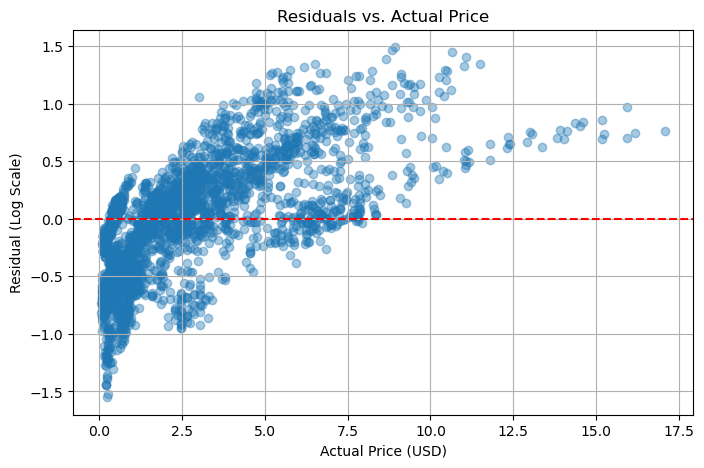

In [76]:
residuals = y_test - y_pred_log
actual_price = np.expm1(y_test)

plt.figure(figsize=(8, 5))
plt.scatter(actual_price, residuals, alpha=0.4)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Actual Price (USD)")
plt.ylabel("Residual (Log Scale)")
plt.title("Residuals vs. Actual Price")
plt.grid(True)
plt.show()


### Ridge Model (log-transformed with alpha=50)

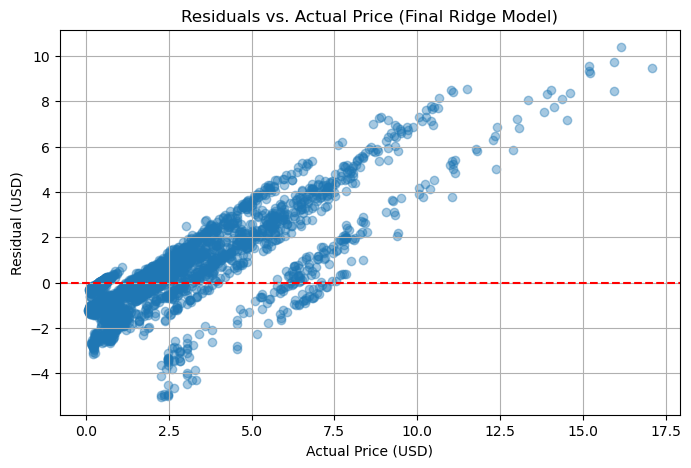

In [81]:
# Fitting final model on train-test split (with alpha=50)
final_ridge = Ridge(alpha=50)
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', final_ridge)
])
ridge_pipeline.fit(X_train, y_train)

# Predict and inverse transform
y_pred_log = ridge_pipeline.predict(X_test)
y_true = np.expm1(y_test)
y_pred = np.expm1(y_pred_log)

# Compute residuals in real price scale
residuals = y_true - y_pred

# Plot residuals vs actual price
plt.figure(figsize=(8, 5))
plt.scatter(y_true, residuals, alpha=0.4)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Actual Price (USD)")
plt.ylabel("Residual (USD)")
plt.title("Residuals vs. Actual Price (Final Ridge Model)")
plt.grid(True)
plt.show()


### Comments:

1. Initially, residuals increased with actual price, indicating underprediction on high-cost commodities.
   
2. After tuning the Ridge model (alpha = 50), residuals became more balanced and centered around zero, confirming improved fit and stability across all price levels. The model's error isn’t escalating with higher prices the way it was before.


<div style="border: double black; background: linear-gradient(to right, white,lightblue);">
<h1 style="text-align:center" > Summary </h1>
<p> This project used Ridge regression with a log-transformed price target to model food commodity prices in Haiti. Despite exploring alternatives like <strong>Random Forest</strong> and seasonal features, <strong>Ridge</strong>(alpha = 50) offered a more robust baseline for future forecasting. Residual plots confirmed a good fit with no major bias, supporting its use for baseline forecasting. . </p>
<hr style="border: solid white; background-color: white">
<h3 style="text-align: center;"> Presented by:
<a href="https://www.linkedin.com/in/carllegros/" target="_blank" style="color:blue"> Carl Legros</a>
</h3>
</div>